##  Calculating anomaly and trend with sea ice thickness time series

In this exercise, we will use the sea ice thickness data in the Arctic region, available through the PolarWatch data server, to study changes in monthly average sea ice thickness values.  We will compare the current state of sea ice thickness to the historical mean and also evaluate the long-term trend from the data. 



### The exercise demonstrates the following techniques:
- Loading twice daily sea ice thickness data of the year 2023 from ERDDAP using `xarray` and compute monthly average
- Loading multi-year monthly average sea ice thickness data from netCDF file
- Calculating the historical sea ice thickness monthly means
- Calculating anomalies (departures from the historical means)
- Calculating the trend of monthly sea ice thickness means for the climatological reference period of 2006 to 2020 (15 years)
- Visualizing the data 

### Datasets used:
- __Sea ice thickness for the Arctic from the NOAA Climate Data Record (CDR)__ of the Extended Polar Pathfinder cryosphere dataset from NCEI. Twice daily data are available from 1982 to present.
 https://polarwatch.noaa.gov/catalog/ice-thick-sq-nh-appx/preview/?dataset=daily&var=cdr_sea_ice_thickness&time_min=2024-08-28T14:00:00Z&time_max=2024-08-28T14:00:00Z&proj=epsg3413&colorBar=KT_amp|||0|3|

- 25-km sea ice thickess monthly average data from 2006 to 2020.

_In this exercise, monthly means were computed from the 25-km sea ice thickness dataset under the assumption of equal sampling and no missing data. Therefore, no weights were applied in this instance. In cases where data gaps or uneven sampling occur, applying appropriate weights is recommended for more accurate climatological calculations._


### Import Python packages

In [1]:
# Load packages
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymannkendall as mk

### Load data from PolarWatch ERDDAP data server

We will begin by obtaining the current sea ice thickness data from the PolarWatch ERDDAP data server. 
The data request is made using a URL that includes the ERDDAP address and a unique dataset ID.


In [8]:
# Define the URL for the PolarWatch sea ice thickness dataset on the ERDDAP server
erddap_url = "https://polarwatch.noaa.gov/erddap/griddap/ncei_polarAPPX20_nhem"  

# Use xarray function to load the dtaset from the EREDDAP URL
ds = xr.open_dataset(erddap_url)   

# Display the dataset metadata 
ds

<xarray.Dataset> Size: 310GB
Dimensions:                                    (time: 29729, rows: 361,
                                                columns: 361)
Coordinates:
  * time                                       (time) datetime64[ns] 238kB 19...
  * rows                                       (rows) float32 1kB -4.5e+06 .....
  * columns                                    (columns) float32 1kB -4.525e+...
Data variables: (12/20)
    cdr_sea_ice_thickness                      (time, rows, columns) float32 15GB ...
    cdr_surface_temperature                    (time, rows, columns) float32 15GB ...
    cdr_surface_albedo                         (time, rows, columns) float32 15GB ...
    cdr_surface_downwelling_shortwave_flux     (time, rows, columns) float32 15GB ...
    cdr_surface_downwelling_longwave_flux      (time, rows, columns) float32 15GB ...
    cdr_surface_upwelling_shortwave_flux       (time, rows, columns) float32 15GB ...
    ...                                         ...
    cloud_optical_depth                        (time, rows, columns) float32 15GB ...
    cloud_top_pressure                         (time, rows, columns) float32 15GB ...
    cloud_top_temperature                      (time, rows, columns) float32 15GB ...
    cloud_type                                 (time, rows, columns) float32 15GB ...
    surface_shortwave_cloud_radiative_forcing  (time, rows, columns) float32 15GB ...
    surface_longwave_cloud_radiative_forcing   (time, rows, columns) float32 15GB ...
Attributes: (12/44)
    _NCProperties:              version=2,netcdf=4.8.1,hdf5=1.10.6
    acknowledgement:            Please acknowledge NCEI, CoastWatch West Coas...
    cdm_data_type:              Grid
    cdr_program:                NOAA Climate Data Record Program for satellites
    cdr_variable:               cdr_surface_temperature, cdr_surface_albedo, ...
    comment:                    In order to be compliant with the EASE Grid s...
    ...                         ...
    spatial_resolution:         25 km
    standard_name_vocabulary:   CF Standard Name Table (v26, 08 November 2013)
    summary:                    summary
    time_coverage_end:          2024-09-19T14:00:00Z
    time_coverage_start:        1982-01-01T04:00:00Z
    title:                      Sea Ice Thickness and Multi-variable Extended...

### Load 2021 data and compute monthly average

__Note__: Running this code snippet may take some time (about 10 minutes), 
depending on the available resources of your computer. 
If you encounter any issues running the code, you can load the final dataset, 
`ds_23_monthly.nc`, located in the `data/` folder to continue with the exercise.

```
# Load data from year 2021
ds21 = ds.sel(time=slice('2023-01-01', '2023-12-31'))

# Compute montly average
ds_monthly_mean21 = ds21.groupby("time.month").mean()

# Close dataset to free up memory
ds21.close()
```


In [ ]:
# Load data from year 2021
ds23 = ds['cdr_sea_ice_thickness'].sel(time=slice('2023-01-01', '2023-12-31'))

# Compute montly average
ds_monthly_mean23_2 = ds23.groupby("time.month").mean()

# Close dataset to free up memory
ds23.close()



In [2]:
# Load already computed monthly mean for 2021
ds_monthly_mean23 = xr.open_dataset('../data/sit_monthly_mean23.nc')
ds_monthly_mean23

<xarray.Dataset> Size: 6MB
Dimensions:                (rows: 361, columns: 361, month: 12)
Coordinates:
  * rows                   (rows) float32 1kB -4.5e+06 -4.475e+06 ... 4.525e+06
  * columns                (columns) float32 1kB -4.525e+06 -4.5e+06 ... 4.5e+06
  * month                  (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    cdr_sea_ice_thickness  (month, rows, columns) float32 6MB ...

### Visualizing 2023 January Monthly Average on the Map


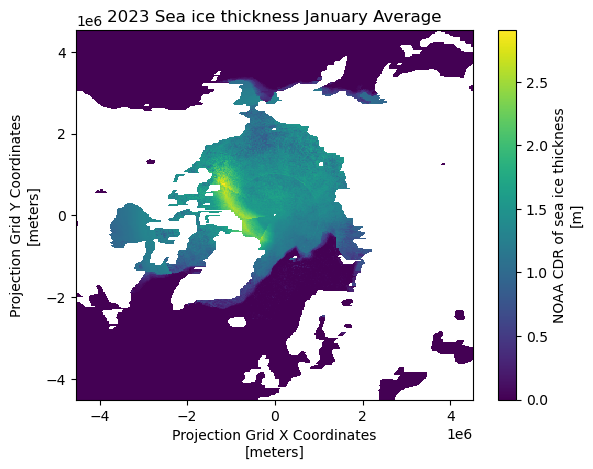

In [5]:
# Visualize the January sea ice thickness mean (first time step: index[0])
ds_monthly_mean23['cdr_sea_ice_thickness'][0].plot()
plt.title("2023 Sea ice thickness January Average")
plt.show()

### Loading Monthly Average from 2006 to 2020

To do climate analysis such as computing climatology and trend analysis, 
we will use sea ice thickness monthly average from 2005 to 2020.  The monthly averages are already computed and are available in netcdf file.

In [6]:
# Load monthly average data from 2006-2020
ds_monthly = xr.open_dataset('../data/seaice-thickness-monthly2006_2020.nc')
ds_monthly

<xarray.Dataset> Size: 94MB
Dimensions:                (year: 15, month: 12, rows: 361, columns: 361)
Coordinates:
  * rows                   (rows) float32 1kB -4.5e+06 -4.475e+06 ... 4.525e+06
  * columns                (columns) float32 1kB -4.525e+06 -4.5e+06 ... 4.5e+06
  * month                  (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * year                   (year) int64 120B 2006 2007 2008 ... 2018 2019 2020
Data variables:
    cdr_sea_ice_thickness  (year, month, rows, columns) float32 94MB ...

### Compute the 15 year historical mean

Using `ds_monthly` dataset, we will compute 15 year historical monthly means.



In [7]:
# Compute monthly mean from annualized data
historical_mean = ds_monthly.mean(dim='year')
ds_monthly.close()
historical_mean

<xarray.Dataset> Size: 6MB
Dimensions:                (month: 12, rows: 361, columns: 361)
Coordinates:
  * rows                   (rows) float32 1kB -4.5e+06 -4.475e+06 ... 4.525e+06
  * columns                (columns) float32 1kB -4.525e+06 -4.5e+06 ... 4.5e+06
  * month                  (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    cdr_sea_ice_thickness  (month, rows, columns) float32 6MB 0.0 0.0 ... 0.0

### Visualizing monthly historical mean

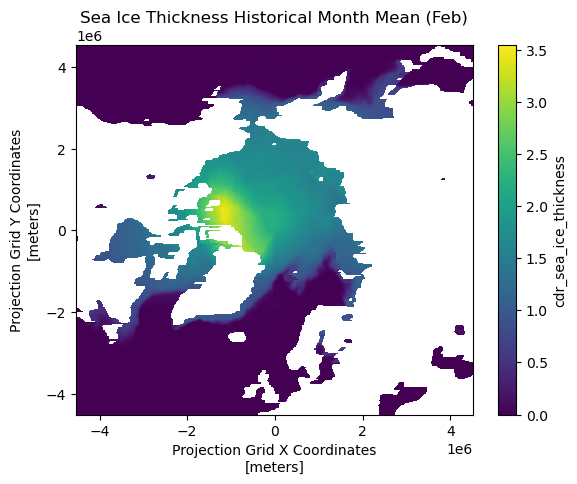

In [8]:
# Plot the first time step of the sea ice thickness
historical_mean['cdr_sea_ice_thickness'][1].plot()
plt.title("Sea Ice Thickness Historical Month Mean (Feb)")
plt.show()

### Computing Anomalies  

To assess recent changes in sea ice thickness, we can compare the current sea ice thickness for the year 2023 to the 15-year historical mean.  An anaomaly is a commonly used metric that represents the difference (or departure) between the current value and the historical average. 

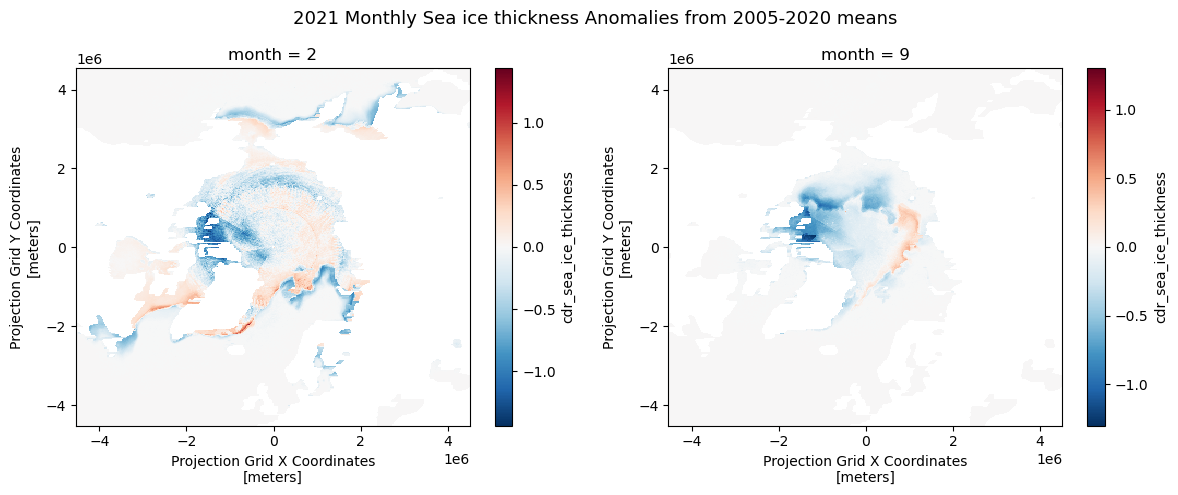

In [54]:
# Compute anomaly of 2021 from the mean data
anom_mean = ds_monthly_mean23['cdr_sea_ice_thickness'] - historical_mean['cdr_sea_ice_thickness']

# Plot Feb and Sep anomaly
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
anom_mean[1].plot(ax=axs[0])
anom_mean[8].plot(ax=axs[1])

# Set the title
fig.suptitle('2021 Monthly Sea ice thickness Anomalies from 2005-2020 means', fontsize=13)

# Adjust the layout
plt.tight_layout()

# Display the plots
plt.show()


### Computing Trends

https://www.geeksforgeeks.org/how-to-perform-a-mann-kendall-trend-test-in-python/

A trend in climatology refers to long-term changes over an extended period.  There are several methods to estimate the trends in the time series data.   In this exercise, we will use Mann-Kendall regression with `mk_slope()` function to compute the slope.  Mann-Kendall test is a non-parametric method that does not assume data normality, making it suitable for various data distributions. 

Note: The code may take some time to process (approximately 3 minutes).

In [57]:

# Define a function to apply the Mann-Kendall test and return the slope
def mk_slope(data):

# remove NaN data points
    clean_data = data[~np.isnan(data)]
# if data points not enough, return Nan 
    if len(clean_data) < 2:
            return np.nan     
    # Apply MK analysis
    result = mk.original_test(data)
    # Return only slope
    return result.slope

# Using xarray.apply_ufunc(), we will apply mk_slope across the 'time' (monthly)  dimension for each grid
# Apply the function across the 'time' dimension for each pixel
slopes = xr.apply_ufunc(
    mk_slope,                # The function to apply
    ds_monthly,                    # The data 
    input_core_dims=[['year']],  # The dimension over which to apply the function
    vectorize=True,          # Vectorize to apply across all grid
    dask='parallelized',     # Enable parallel processing if using Dask
    output_dtypes=[float]    # The output type (float for slope)
)



### Visualizing the Trends (Slopes) for Each Grid

The slopes are calculated for each month and grid over the 15-year-period (2005-2020).  
For this visualization, we will display the results from the month of September across the grid.

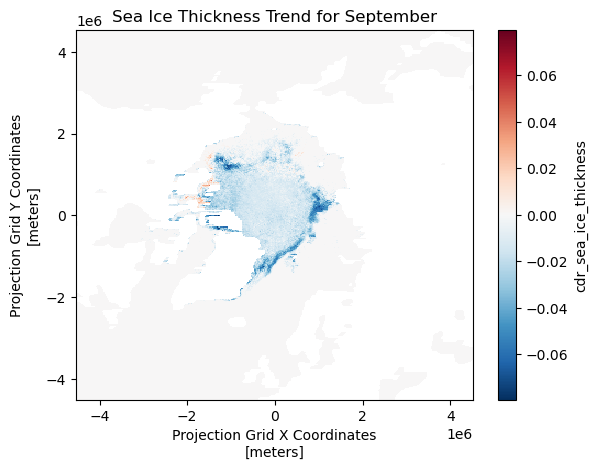

In [65]:
slopes['cdr_sea_ice_thickness'].sel(month=9).plot()

plt.title('Sea Ice Thickness Trend for September')

# Show the plot
plt.show()